In [168]:
import pandas as pd
import datetime
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt

# 1. Подготовка данных. 
Сделаем две таблицы `DIVIDENS` и `price`. Первая таблицв содержит данные и дивидендах компаний, вторая содержит данные о котировках акций.

In [80]:
div = pd.read_csv('DIVIDENDS.csv')

div['date'] = pd.to_datetime(div['date'])

In [82]:
div.head()

,date,dividends,type,ticker,currency
0,1987-09-21,2,Stock Split,MSFT,USD
1,1990-04-16,2,Stock Split,MSFT,USD
2,1991-06-27,"1,5",Stock Split,MSFT,USD
3,1992-06-15,"1,5",Stock Split,MSFT,USD
4,1994-05-23,2,Stock Split,MSFT,USD


In [83]:
price = pd.read_csv('price.csv')

price['Date'] = pd.to_datetime(price['Date'])

In [84]:
price.head()

,Date,Price,ticker,currency
0,2014-08-22,"45,16",MSFT,USD
1,2014-08-25,"45,17",MSFT,USD
2,2014-08-26,"45,005",MSFT,USD
3,2014-08-27,"44,87",MSFT,USD
4,2014-08-28,"44,88",MSFT,USD


# 2. Подсчёт индекса. 

## 2.1. Цена динамической корзины. 
Обозначии цену динамической корзины как $PDB$ (price dynamic bucket). Явная формула:
$$
    PDB_{t} = PDB_{t - 1} \cdot \left (1 + \sum_{i = 1}^{5} w_i \cdot \Delta price\_stock_i \right).
$$
- При $t = 0$ дата -- `15-01-2020`. Чтобы подсчитывать значения для отрцитательных $t$ нужно просто вырзазить $PDB_{t - 1}$. При $t = 0$ $PDB_{t = 0} = 100 \%$.
- Веса $w_i$ считаются, как доля в процентах в динамической корзине.

In [307]:
#init PDB
start_date = pd.to_datetime('30.10.2014')
day_delta = datetime.timedelta(days=1)
finish_date = pd.to_datetime('28.07.2020')

last_price = {'FB' : 0,
             'MSFT' : 0,
             'HK' : 0,
             'AAPL' : 0,
              'GOOGL' : 0
             }

t0_date = pd.to_datetime('15.01.2020')

In [308]:
div_dates = []

In [320]:
prices = [100 for i in range((finish_date - start_date).days)]

#move up
index_start = t0_date - start_date
for i in range(1, len(prices)):
    date_ = start_date + i * day_delta
    prev_date_ = start_date + (i - 1) * day_delta
    w = np.array([0.20 for i in range(5)])
    #make array of delta price
    delta_p = []
    tickers = set(price['ticker'])
    for ticker in tickers:
        try:
            price_today = float(price.loc[(price['ticker'] == ticker) & (price['Date'] == date_), 
                                              'Price'].values[0].replace(',', '.'))
        except:
            price_today = last_price[ticker]
            pass
        
        try:
            price_yesterday = float(price.loc[(price['ticker'] == ticker) & (price['Date'] == prev_date_), 
                                              'Price'].values[0].replace(',', '.'))
        except:
            price_yesterday = last_price[ticker]
            pass
        
        try:
            divs = float(div.loc[(div['ticker'] == ticker) & (div['date'] == date_) & 
                                 (div['type'] != 'Stock Split'), 'dividends'].values[0].replace(',', '.'))
            div_dates.append(date_)
        except:
            divs = 0
            pass
        
        last_price[ticker] = price_today
        delta_p.append((price_today + divs * 0.85) / price_yesterday)

    delta_p = np.array([delta_p])
    prices[i] = prices[i - 1] * (np.sum(w * delta_p))

In [321]:
#scaling prices
scale_value = prices[index_start.days]
scale_ratio = 100 / scale_value

for i in range(len(prices)):
    prices[i] *= scale_ratio

In [322]:
PDB = pd.DataFrame({'date' : [start_date + i * day_delta 
                              for i in range((finish_date - start_date).days)], 
                   'price' : prices})

PDB.head()

,date,price
0,2014-10-30,7.136939
1,2014-10-31,7.234665
2,2014-11-01,7.234665
3,2014-11-02,7.234665
4,2014-11-03,7.234665


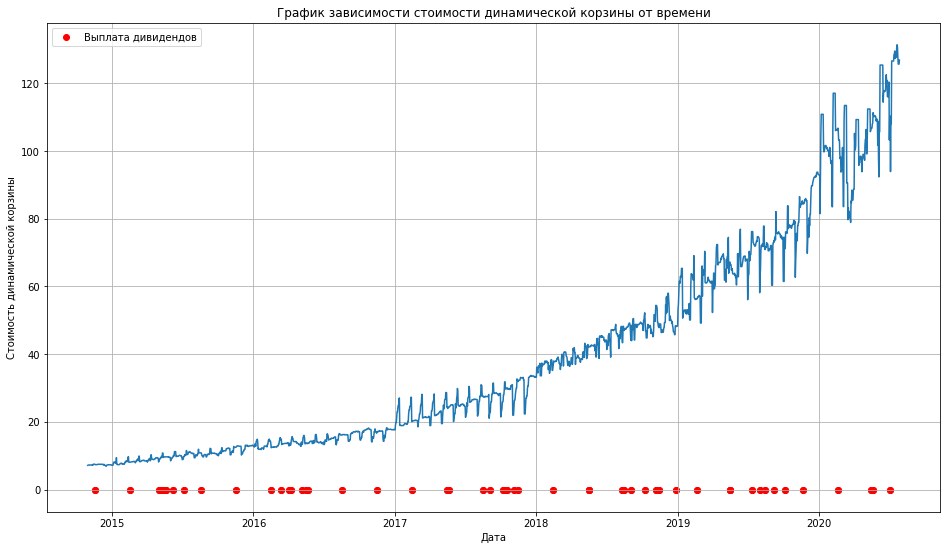

In [323]:
plt.figure(figsize=(16, 9))

plt.plot(
    PDB.loc[:,'date'],
    PDB.loc[:,'price']
)

plt.scatter(
    div_dates,
    [0 for i in range(len(div_dates))],
    c='red',
    label='Выплата дивидендов'
)

plt.legend()
plt.title('График зависимости стоимости динамической корзины от времени')
plt.xlabel('Дата')
plt.ylabel('Стоимость динамической корзины')
plt.grid()
plt.show()

## 2.2. Реализованная волатильность.
Обозначим реализованную волатильность как $RV$ (`realized volatility`). Подсчитаем её по следующей формуле:
$$
    RV_t = \sqrt{252} \cdot \sqrt{\frac{20}{19} \cdot \left[\frac{1}{20}\sum_{j = 1}^{20}\left(\ln \left(\frac{PDB_{t - 20 + j}}{PDB_{t - 20 + j - 1}}\right)\right)^2 - \left(\frac{1}{20}\sum_{j = 1}^{20}\ln\left(\frac{PDB_{t - 20 + j}}{PDB_{t - 20 + j - 1}} \right)   \right)^2 \right]}.
$$

In [324]:
vol_start = start_date - 19 * day_delta

RV = []

for t in range(20, len(PDB)):
    for_sum = np.array([np.log(PDB.loc[PDB['date'] == start_date + (t - 20 + j) * day_delta,'price'].values[0] /  
    PDB.loc[PDB['date'] == start_date + (t - 20 + j - 1) * day_delta, 'price'].values[0]) for j in range(1, 21)])
    sum_2 = for_sum.sum() / 20
    for_sum = for_sum * for_sum
    sum_1 =  for_sum.sum() / 20
    RV_cur = np.sqrt(252 * 20 * (sum_1 - sum_2 * sum_2) / 19)
    RV.append(RV_cur)

In [325]:
RV = pd.DataFrame({'date' : [start_date + i * day_delta 
                              for i in range(20, len(PDB))], 
                   'value' : RV})

RV.head()

,date,value
0,2014-11-19,0.199569
1,2014-11-20,0.195294
2,2014-11-21,0.196038
3,2014-11-22,0.196038
4,2014-11-23,0.196038


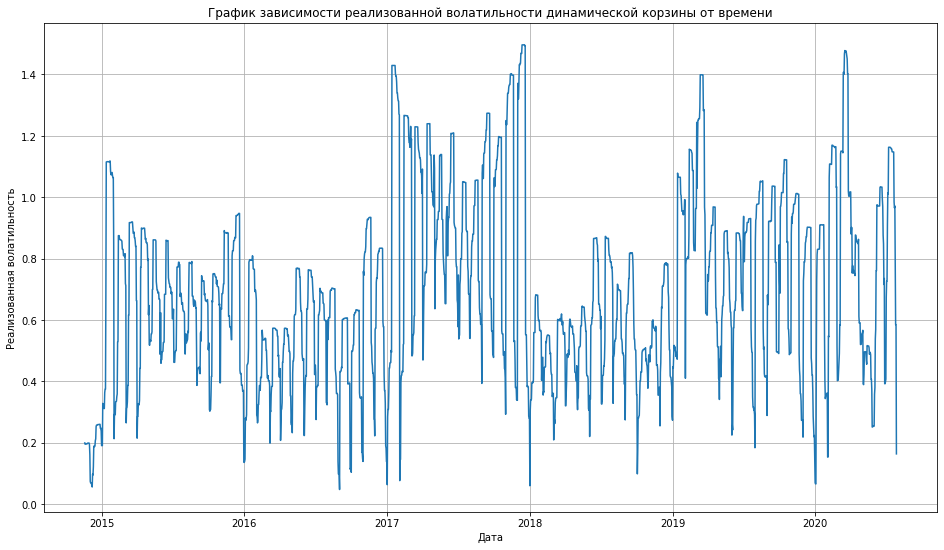

In [326]:
plt.figure(figsize=(16, 9))

plt.plot(
    RV['date'],
    RV['value']
)

plt.title('График зависимости реализованной волатильности динамической корзины от времени')
plt.xlabel('Дата')
plt.ylabel('Реализованная волатильность')
plt.grid()
plt.show()

## 2.3. Зависимость.
Подсчитаем зависимость $Exp$ по следующей формуле:
$$
    Exp_{t - 1} = \min \left [1.2, \frac{0.09}{RV_{t - 2}} \right].
$$

In [316]:
Exp = []
for i in RV['value']:
    Exp.append(min(1.2, 0.09 / i))

In [317]:
dates_exp = [(date + day_delta) for date in RV['date']]

Exp = pd.DataFrame({
    'value' : Exp,
    'date' : dates_exp
    })

In [318]:
Exp.head()

,value,date
0,0.451147,2014-11-20
1,0.461019,2014-11-21
2,0.459261,2014-11-22
3,0.459261,2014-11-23
4,0.459261,2014-11-24


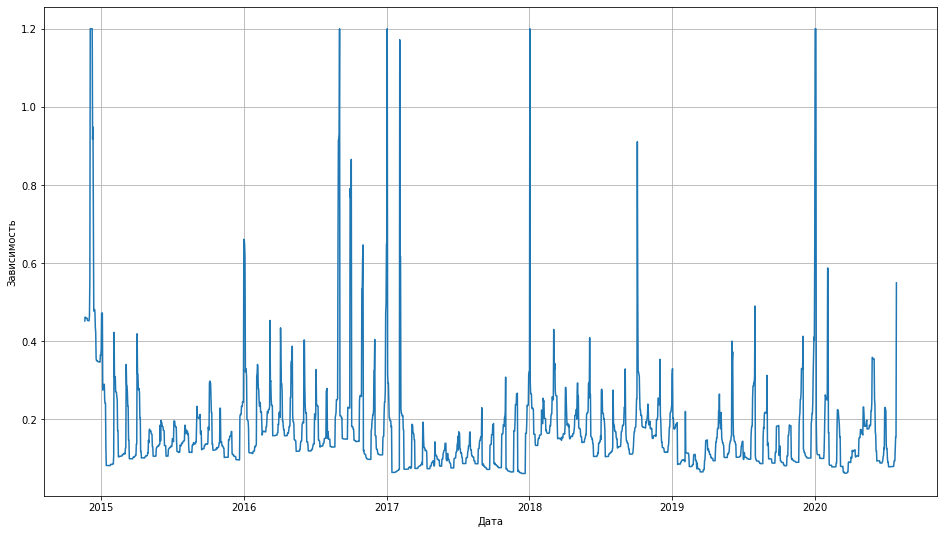

In [319]:
plt.figure(figsize=(16, 9))

plt.plot(
    Exp['date'],
    Exp['value']
)


plt.xlabel('Дата')
plt.ylabel('Зависимость')
plt.grid()
plt.show()

## 2.4. Значение динамической корзины.
Введём обозначение этой величины $VDB$ (`value dynamic bucket`). Рассчитаем значение по формуле:
$$
    VDB_{t} = VDB_{t - 1} \cdot \left[1 + Exp_{t - 1} \cdot \left(\frac{PDB_t}{PDB_{t - 1}} - 1 \right) - Exp_{t - 1} \cdot Rate_{t - 1} \cdot \frac{Fact_{t, t- 1}}{360}
    \right].
$$

In [346]:
rates = pd.read_csv('rates.csv')
rates['date'] = pd.to_datetime(rates['date'])
rates.head()

,date,rate
0,2014-08-22,"0,2384"
1,2014-08-23,"0,2384"
2,2014-08-24,"0,2384"
3,2014-08-25,"0,2384"
4,2014-08-26,"0,2381"


In [398]:
start_date_ = pd.to_datetime('30.12.2014')
VDB = [100.]
last_PDB = PDB.loc[PDB['date'] == pd.to_datetime('30.12.2014'), 'price'].values[0]
fact_0 = 0
last_rate = 0
for i in range(1, (finish_date - start_date_).days):
    date_ = start_date_ + i * day_delta 
    prev_date = date_ - day_delta
    exp = Exp.loc[Exp['date'] == prev_date, 'value'].values[0]
    PDB_t = PDB.loc[PDB['date'] == date_, 'price'].values[0]
    PDB_prev = last_PDB
    try:
        rate = float(rates.loc[rates['date'] == prev_date, 'rate'].values[0].replace(',', '.')) / 100
    except:
        rate = last_rate
    
    VDB.append((1 + exp * (PDB_t/PDB_prev - 1) - exp * rate / 360) * VDB[i - 1])
    last_rate = rate
    last_PDB = PDB_t

In [399]:
VDB = pd.DataFrame({
        'date' : [start_date_ + i * day_delta for i in range((finish_date - start_date_).days)],
        'value' : VDB
    })

VDB.head()

,date,value
0,2014-12-30,100.000000
1,2014-12-31,99.547775
2,2015-01-01,99.547519
3,2015-01-02,99.547251
4,2015-01-03,99.546921


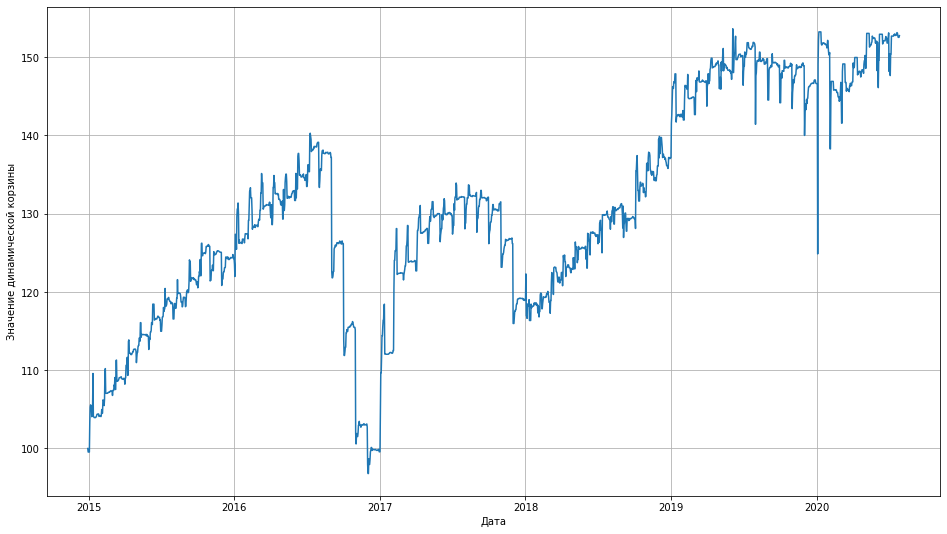

In [400]:
plt.figure(figsize=(16, 9))

plt.plot(
    VDB['date'],
    VDB['value']
)


plt.xlabel('Дата')
plt.ylabel('Значение динамической корзины')
plt.grid()
plt.show()

## 2.5. Вычисление индекса.


In [401]:
index = []
cnt = 0
for i in VDB['value']:
    index.append(i / VDB.loc[VDB['date'] == t0_date, 'value'].values[0] * 100)

In [402]:
index = pd.DataFrame({
        'date' : VDB['date'],
        'price' : index
    })

In [403]:
index.head()

,date,price
0,2014-12-30,65.979710
1,2014-12-31,65.681333
2,2015-01-01,65.681164
3,2015-01-02,65.680987
4,2015-01-03,65.680770


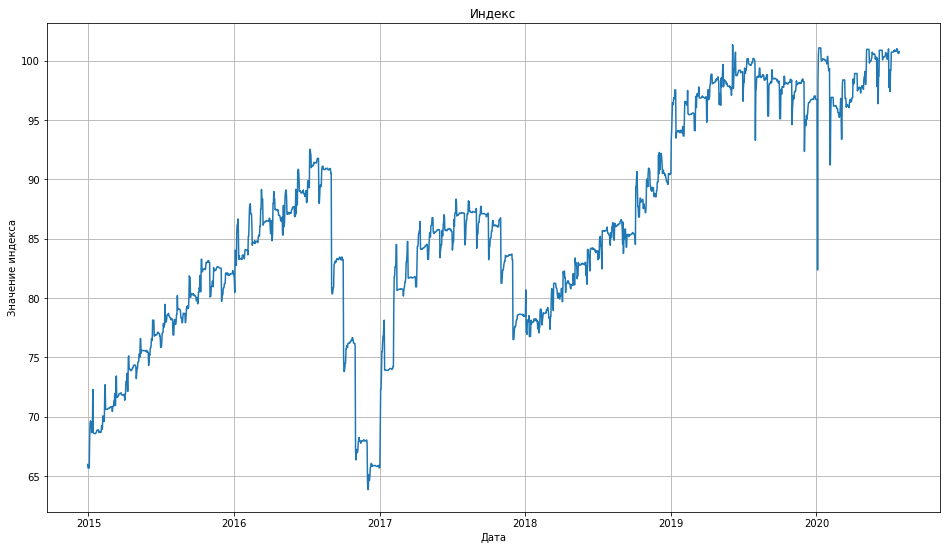

In [404]:
plt.figure(figsize=(16, 9))

plt.plot(
    index['date'],
    index['price']
)

plt.title('Индекс')
plt.xlabel('Дата')
plt.ylabel('Значение индекса')
plt.grid()
plt.show()